In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import scipy.io

In [3]:
matfile = scipy.io.loadmat("ballbeam.mat")
u = matfile["U"]
y = matfile["Y"]

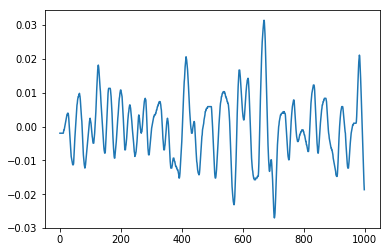

In [4]:
plt.plot(u)
plt.show()

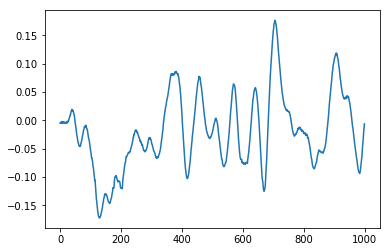

In [5]:
plt.plot(y)
plt.show()

In [6]:
u[:5]

array([[-0.0019635],
       [-0.0019635],
       [-0.0019635],
       [-0.0019635],
       [-0.0019635]])

并没有很多时间，直接考虑用循环神经网络拟合模型，这样状态里也许存着残差信息（或者其他什么东西），LSTM层对一个样本接受一列向量,
如这个向量可能是一个词的嵌入向量或者onehot向量，维度称为input_size，我们这里用前几个样本拼成一个向量（让状态存其他东西）或者一个单维
向量（让状态尝试存之前的信息），可以都试试。网络对一个向量产生一个对应输出与一个状态输出(hidden_size)，状态输出和下一个输入向量一起产生下一个
对应输出与状态输出（初始状态也是要训练的参数）。。。

batch_size \* length \* input_size (batch_first model) 或 length \* batch_size(由于变长问题常取1)  \* input_size (batch_first model)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [8]:
class LSTMSystem(nn.Module):
    # https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html
    def __init__(self, input_dim, hidden_dim, output_dim):
        # input_dim = control_dim + exact_lag_dim(option)
        super(LSTMSystem, self).__init__()
        self.hidden_dim = hidden_dim

        #self.word_embeddings = nn.Embedding(vocab_size, input_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(input_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2out = nn.Linear(hidden_dim, output_dim)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(1, 1, self.hidden_dim),
                torch.zeros(1, 1, self.hidden_dim))

    def forward(self, inputs):
        lstm_out, self.hidden = self.lstm(
            inputs.view(len(inputs), 1, -1), self.hidden)
        tag_space = self.hidden2out(lstm_out.view(len(inputs), -1))
        return tag_space



In [9]:
input_dim = 1
hidden_dim = 2
output_dim = 1
model = LSTMSystem(input_dim, hidden_dim, output_dim)

In [10]:
loss_function = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
# Here we don't need to train, so the code is wrapped in torch.no_grad()
with torch.no_grad():
    inputs = torch.tensor([[1.],[2.],[3.],[4.]])
    output = model(inputs)
    print(output)



tensor([[0.6249],
        [0.6372],
        [0.6203],
        [0.5746]])


In [11]:
inputs = torch.tensor(u, dtype=torch.float)
targets = torch.tensor(y, dtype=torch.float)

In [12]:
cuda = True
if cuda:
    inputs = inputs.cuda()
    targets = targets.cuda()
    model.cuda()

In [ ]:
#%time
for epoch in range(100):  # again, normally you would NOT do 300 epochs, it is toy data
    #for inputs, tags in training_data:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Also, we need to clear out the hidden state of the LSTM,
        # detaching it from its history on the last instance.
        model.hidden = model.init_hidden()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        #sentence_in = prepare_sequence(sentence, word_to_ix)
        #targets = prepare_sequence(tags, tag_to_ix)
        

        # Step 3. Run our forward pass.
        output = model(inputs)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(output, targets)
        print(loss.item())
        
        loss.backward()
        optimizer.step()



In [44]:
        print(loss.item())


0.004513183142989874


In [43]:
# See what the scores are after training
with torch.no_grad():
    output = model(inputs)

    # The sentence is "the dog ate the apple".  i,j corresponds to score for tag j
    # for word i. The predicted tag is the maximum scoring tag.
    # Here, we can see the predicted sequence below is 0 1 2 0 1
    # since 0 is index of the maximum value of row 1,
    # 1 is the index of maximum value of row 2, etc.
    # Which is DET NOUN VERB DET NOUN, the correct sequence!
    print(output)


tensor([[-0.0208],
        [-0.0207],
        [-0.0206],
        [-0.0206],
        [-0.0206],
        [-0.0206],
        [-0.0206],
        [-0.0206],
        [-0.0206],
        [-0.0206],
        [-0.0206],
        [-0.0206],
        [-0.0206],
        [-0.0205],
        [-0.0205],
        [-0.0204],
        [-0.0204],
        [-0.0203],
        [-0.0202],
        [-0.0201],
        [-0.0201],
        [-0.0200],
        [-0.0199],
        [-0.0198],
        [-0.0198],
        [-0.0198],
        [-0.0198],
        [-0.0198],
        [-0.0198],
        [-0.0200],
        [-0.0202],
        [-0.0204],
        [-0.0206],
        [-0.0209],
        [-0.0211],
        [-0.0213],
        [-0.0214],
        [-0.0216],
        [-0.0217],
        [-0.0218],
        [-0.0219],
        [-0.0219],
        [-0.0220],
        [-0.0220],
        [-0.0220],
        [-0.0220],
        [-0.0217],
        [-0.0215],
        [-0.0212],
        [-0.0209],
        [-0.0207],
        [-0.0204],
        [-0.

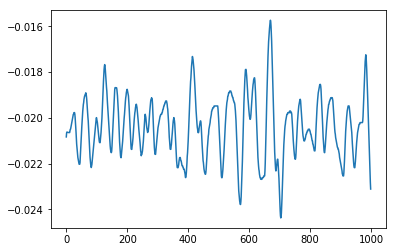

In [46]:
plt.plot(output.numpy())